# Demo

In [61]:
import financial.data as fd
import financial.model as fm

import numpy as np
import pandas as pd
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' # INFO and WARNING messages are not printed (TensorFlow)

In [62]:
from financial.io.cache import NoUpdateStrategy
from financial.io.file.cache import FileCache

print(os.environ["DATA"])
print(os.environ["CACHE"])
ds = fd.CachedDataStore(path=os.environ["DATA"], cache=FileCache(cache_path=os.environ["CACHE"]+"/", update_strategy=NoUpdateStrategy()))

print(ds)

/home/manidmt/Universidad/TFG/OTRI/data
/home/manidmt/Universidad/TFG/OTRI/cache
CachedDataStore with 946 data sources [cache stats: {'size': 0, 'hit': 0, 'miss': 0, 'write': 0, 'read': 0, 'update': 0}]


## Acceso a los datos

In [63]:
# Datos históricos de un ticker concreto, p.ej. ^GSPC (S&P 500)
start_date = '1990-01-01'
end_date = '2024-12-31'
ticker = '^GSPC'

data = ds.get_data(ticker, start_date, end_date)
print(data)

1990-01-02     359.690002
1990-01-03     358.760010
1990-01-04     355.670013
1990-01-05     352.200012
1990-01-08     353.790009
                 ...     
2024-12-24    6040.040039
2024-12-26    6037.589844
2024-12-27    5970.839844
2024-12-30    5906.939941
2024-12-31    5881.629883
Name: ^GSPC, Length: 8817, dtype: float64


^GSPC, from 1990-01-02 to 2024-12-31


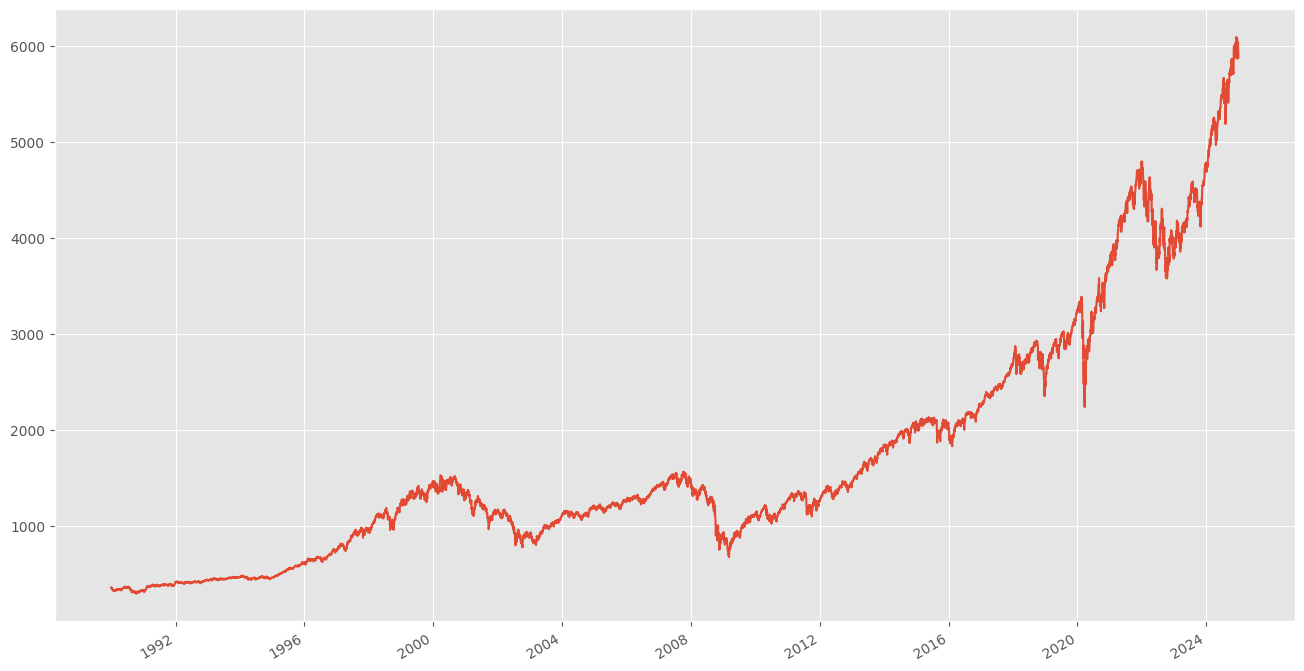

In [64]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import style

# Adjusting the size of matplotlib
import matplotlib as mpl

mpl.rc('figure', figsize=(16, 9))
mpl.__version__

# Adjusting the style of matplotlib
style.use('ggplot')


def plot_data(data: pd.Series) -> None:
    data.plot()
    start_date = data.index[0].date()
    end_date = data.index[-1].date()
    print(f"{data.name}, from {start_date} to {end_date}")

plot_data(data)

# Hiperparámetros

In [65]:
# Declarative model specification

experiment_id = 'exponential-regression-model'
lookahead = 20 # i.e. ~ 1 mes (4 semanas)
horizon   = 90 # Clenow

hyperparameters = {
        "input": {
            "features": "local_regression_features_wrapper"
            # "normalization": { "method": "z-score", "start_index": start_date, "end_index": end_date }
            },
        "output": {
            "target": [ticker],
            "lookahead": lookahead,
            "prediction": "relative" # "absolute"|"relative"
            # "normalization": { "method": "z-score", "start_index": start_date, "end_index": end_date }
            },    
}

print(f"Experiment '{experiment_id}'")
print(hyperparameters)

Experiment 'exponential-regression-model'
{'input': {'features': 'local_regression_features_wrapper'}, 'output': {'target': ['^GSPC'], 'lookahead': 20, 'prediction': 'relative'}}


# E/S de un modelo autorregresivo

In [66]:
# Entradas 

def local_regression_features(ds: fd.DataStore, ticker: str) -> fd.Set:
    features = fd.Set('Local exponential regression model features')    
    variable = fd.Variable(ticker)
    features.append(variable)
    return features


print("MODEL INPUTS")
inputs = local_regression_features(ds,ticker)
print(inputs)
print(inputs.to_xml_string())


MODEL INPUTS
Local exponential regression model features(^GSPC)
<set id="Local exponential regression model features"><variable id="^GSPC" /></set>


In [67]:
# Salidas 

def output_descriptor(hyperparameters: dict, ds: fd.DataStore = None) -> fd.DataDescriptor:
    outputs = fd.Set('outputs')
    for output in hyperparameters["output"]["target"]:
        variable = fd.Variable(output) 
        lookahead = hyperparameters["output"]["lookahead"]
        target = fd.LookAhead(variable, lookahead)
        outputs.append( target )            
    return outputs

outputs = output_descriptor(hyperparameters, ds)
print(outputs)
print(outputs.to_xml_string())
print(outputs.variables[0].get_data(ds,start_date, end_date)[:-lookahead])
print(data[lookahead:])

outputs(lookahead(^GSPC,20))
<set id="outputs"><lookahead periods="20"><variable id="^GSPC" /></lookahead></set>
1990-01-02     322.980011
1990-01-03     329.079987
1990-01-04     328.790009
1990-01-05     330.920013
1990-01-08     331.850006
                 ...     
2024-11-25    6040.040039
2024-11-26    6037.589844
2024-11-27    5970.839844
2024-11-29    5906.939941
2024-12-02    5881.629883
Name: ^GSPC, Length: 8797, dtype: float64
1990-01-30     322.980011
1990-01-31     329.079987
1990-02-01     328.790009
1990-02-02     330.920013
1990-02-05     331.850006
                 ...     
2024-12-24    6040.040039
2024-12-26    6037.589844
2024-12-27    5970.839844
2024-12-30    5906.939941
2024-12-31    5881.629883
Name: ^GSPC, Length: 8797, dtype: float64


In [68]:
# Wrappers

print(local_regression_features(ds,ticker))
print(globals()["local_regression_features"](ds,ticker))

def local_regression_features_wrapper(ds: fd.DataStore) -> fd.Set:
    return local_regression_features(ds,ticker)

print(globals()["local_regression_features_wrapper"](ds))

Local exponential regression model features(^GSPC)
Local exponential regression model features(^GSPC)
Local exponential regression model features(^GSPC)


# Modelo

In [69]:
import financial.lab.models as labmodels
import sklearn.linear_model

from financial.momentum.exponentialRegression import ExponentialRegressionModelFactory

'''
class LinearScikitLearnModelFactory (labmodels.ModelFactory):

    # Linear regression Scikit-Learn model factory

        
    def create_model_from_descriptors(self, 
                                      model_id: str, 
                                      hyperparameters: dict, 
                                      input_descriptor: fd.DataDescriptor, 
                                      output_descriptor: fd.DataDescriptor) -> fm.Model:
        model = sklearn.linear_model.LinearRegression()
        return fm.ScikitLearnModel(model_id, input_descriptor, output_descriptor, model, hyperparameters)
        

factory = LinearScikitLearnModelFactory()
'''

factory = ExponentialRegressionModelFactory()
model = factory.create_model(experiment_id, hyperparameters, ds)

# NOTE: Model is stored in the following files 
# - {experiment_id}.pickle (scikit-learn model, in binary format)
# - {experiment_id}.xml (model metadata specification, in XML format)
# - {experiment_id}.hyperparameters.json (model hyperparameters [dict])

print(model)
print(model.to_xml_string())


LinearRegression{'copy_X': True, 'fit_intercept': True, 'n_jobs': None, 'positive': False}
<?xml version="1.0" ?>
<model id="exponential-regression-model">
  <input>
    <set id="Local exponential regression model features">
      <variable id="^GSPC"/>
    </set>
  </input>
  <target>
    <set id="outputs">
      <change period="-20">
        <variable id="^GSPC"/>
      </change>
    </set>
  </target>
</model>



# Conjunto de datos

In [70]:
import financial.lab.data as labdata

print(data)

df = pd.DataFrame(data, index = data.index)

print(df)

#df['days_from_start'] = (df.index - df.index[0]).days
df['day'] = range(len(df))

print(df)
df.describe()

1990-01-02     359.690002
1990-01-03     358.760010
1990-01-04     355.670013
1990-01-05     352.200012
1990-01-08     353.790009
                 ...     
2024-12-24    6040.040039
2024-12-26    6037.589844
2024-12-27    5970.839844
2024-12-30    5906.939941
2024-12-31    5881.629883
Name: ^GSPC, Length: 8817, dtype: float64
                  ^GSPC
1990-01-02   359.690002
1990-01-03   358.760010
1990-01-04   355.670013
1990-01-05   352.200012
1990-01-08   353.790009
...                 ...
2024-12-24  6040.040039
2024-12-26  6037.589844
2024-12-27  5970.839844
2024-12-30  5906.939941
2024-12-31  5881.629883

[8817 rows x 1 columns]
                  ^GSPC   day
1990-01-02   359.690002     0
1990-01-03   358.760010     1
1990-01-04   355.670013     2
1990-01-05   352.200012     3
1990-01-08   353.790009     4
...                 ...   ...
2024-12-24  6040.040039  8812
2024-12-26  6037.589844  8813
2024-12-27  5970.839844  8814
2024-12-30  5906.939941  8815
2024-12-31  5881.629883  8816

,^GSPC,day
count,8817.000000,8817.000000
mean,1693.774250,4408.000000
std,1251.936187,2545.392995
min,295.459991,0.000000
25%,909.700012,2204.000000
50%,1283.719971,4408.000000
75%,2100.800049,6612.000000
max,6090.270020,8816.000000


# Entrenamiento del Modelo

In [71]:
def create_local_model(start_index: int=0, samples: int=horizon) -> fm.Model:
    model = factory.create_model(experiment_id, hyperparameters, ds)
    #print(model)

    series = data[start_index:start_index+samples]
    subset = pd.DataFrame(series, index = data.index[start_index:start_index+samples])
    subset['day'] = range(-len(subset)+1,1)
    #print(subset)
    #print(subset.count())

    model.fit(subset[['day']],subset[ticker])
    #print(vars(model.model))
    return model

model = create_local_model(0, horizon)
print(model)
print(vars(model.model))
print(model.model.coef_)
print(model.model.intercept_)
print(model.predict([[lookahead]]))
print(model.model.intercept_+model.model.coef_[0]*lookahead)

model = create_local_model(len(df)-horizon, horizon)
print(model)
print(vars(model.model))
print(model.model.coef_)
print(model.model.intercept_)
print(model.predict([[lookahead]]))
print(model.model.intercept_+model.model.coef_[0]*lookahead)

LinearRegression{'copy_X': True, 'fit_intercept': True, 'n_jobs': None, 'positive': False}
{'fit_intercept': True, 'copy_X': True, 'n_jobs': None, 'positive': False, 'n_features_in_': 1, 'coef_': array([-5.03458836e-05]), 'rank_': 1, 'singular_': array([246.45993589]), 'intercept_': 5.817733309185066}
[-5.03458836e-05]
5.817733309185066
[335.87074267]
5.816726391513484
LinearRegression{'copy_X': True, 'fit_intercept': True, 'n_jobs': None, 'positive': False}
{'fit_intercept': True, 'copy_X': True, 'n_jobs': None, 'positive': False, 'n_features_in_': 1, 'coef_': array([0.00100979]), 'rank_': 1, 'singular_': array([246.45993589]), 'intercept_': 8.714295387194417}
[0.00100979]
8.714295387194417
[6213.57226038]
8.734491252755504


In [72]:
def local_regression(data, factory, samples: int=horizon):
    forecast = pd.Series(index=data.index)
    for index in range(len(df)-samples):
        model = create_local_model(index, samples)
        forecast.iloc[index+horizon] = model.predict([[lookahead]])
    forecast = forecast.shift(lookahead)
    return forecast


forecast = local_regression(data, factory, samples=horizon)
print(forecast.dropna())   

1990-06-08     335.870743
1990-06-11     337.083386
1990-06-12     338.748582
1990-06-13     340.473946
1990-06-14     342.057775
                 ...     
2024-12-24    6112.331674
2024-12-26    6125.678101
2024-12-27    6143.003368
2024-12-30    6158.134795
2024-12-31    6169.437513
Length: 8707, dtype: float64


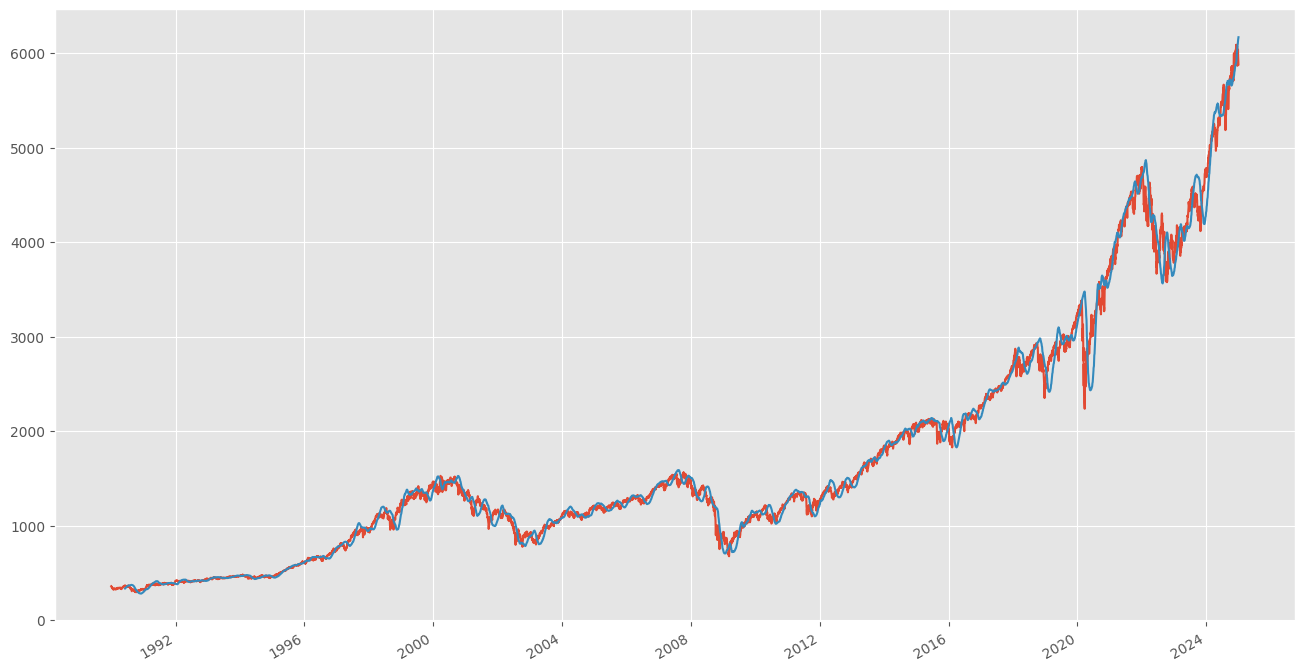

In [73]:
def plot_series(series: list[pd.Series], start_date: str=None, end_date: str=None):
    for serie in series:
        serie[start_date:end_date].plot()

plot_series([data, forecast])

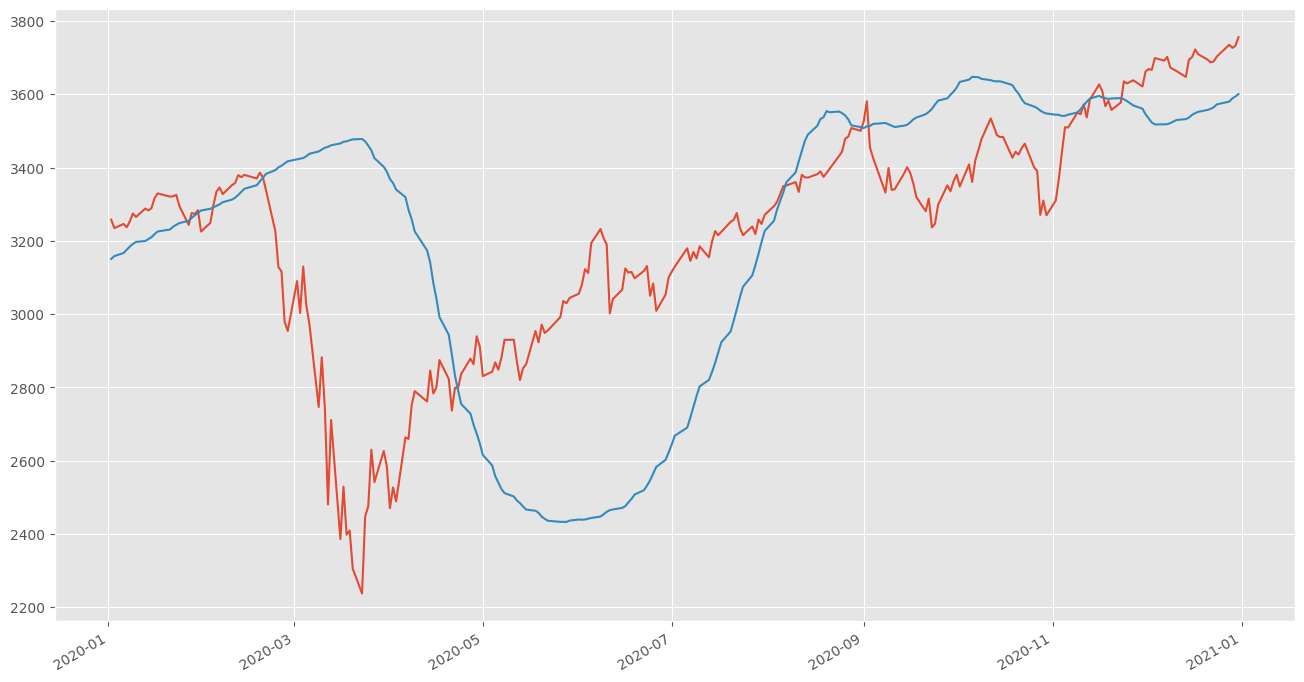

In [74]:
plot_series([data, forecast],'2020-01-01','2020-12-31')

In [75]:
from financial.lab.experiment import Experiment

prediction = forecast.dropna() 
target = data[horizon+lookahead:]

experiment = Experiment(experiment_id, prediction, target)
print(f"n = {experiment.samples()}")
print(f"MSE = {experiment.MSE():.4f}")
print(f"RMSE = {experiment.RMSE():.4f}")
print(f"MAE = {experiment.MAE():.4f}")
print(f"MAPE = {experiment.MAPE():.4f}")

n = 8707
MSE = 14856.6335
RMSE = 121.8878
MAE = 73.5603
MAPE = 0.0440


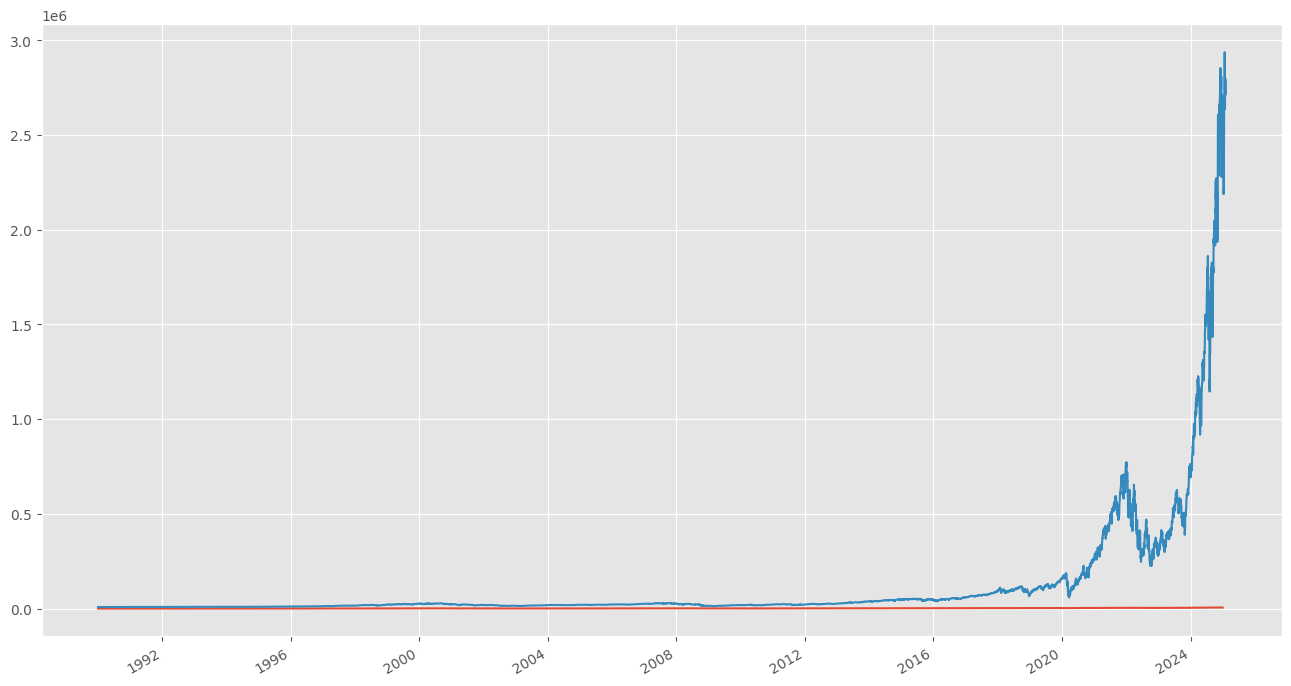

In [76]:
model_prediction = model.get_data(ds, start_date)

plot_series([data, model_prediction])

In [77]:
from sklearn.metrics import r2_score

r2 = r2_score(target, prediction)

print(f"R² = {r2:.4f}")


R² = 0.9905
